# **Distracted Driver Detection**
### **Image Classification with Deep Learning**
### **Model 6 — MobileNetV2 Transfer Learning (Batch 150 · SGD · α = 0.003)**

--------------------------

# **Project Overview**

Distracted driving is one of the leading causes of road accidents worldwide. This project explores whether a Computer Vision model can accurately detect and classify different driver behaviors from in-car images, enabling real-time distraction detection systems.

Given a dataset of driver images captured inside vehicles, the goal is to classify each image into one of **10 distraction categories**:

- **c0:** Safe driving
- **c1:** Texting — right
- **c2:** Talking on the phone — right
- **c3:** Texting — left
- **c4:** Talking on the phone — left
- **c5:** Operating the radio
- **c6:** Drinking
- **c7:** Reaching behind
- **c8:** Hair and makeup
- **c9:** Talking to passenger

This notebook applies **MobileNetV2 transfer learning** with the **SGD optimizer** — a lightweight, mobile-optimized architecture designed for efficient inference while maintaining competitive accuracy.

--------------------------

# **Implementation**

### **• Libraries and Module Imports:**

Importing the necessary libraries and modules to manipulate and interact with the dataset.

In [1]:
# Importing the necessary libraries and modules.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import tensorflow as tf
import os
from random import randint
import random
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.models import load_model
from keras.models import save_model
from keras import backend as K
from keras.applications import MobileNetV2
from keras import backend as K
from keras import Model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
import seaborn as sns

### **• Loading the Data:**

Loading the Drivers list CSV and setting the paths for the Training and Testing images.

In [2]:
# Loading the Driver Images list CSV.
drivers_images_list_df = pd.read_csv('Data/driver_imgs_list.csv')

In [3]:
# Checking the information and schema of the dataframe.
drivers_images_list_df.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [4]:
# Defining the Training images folder path in order to feed the different models.
training_folder_path = 'Data/imgs/train'

In [5]:
# Defining the Training images folder path in order to feed the different models.
testing_folder_path = 'Data/imgs/test'

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### **PART I: Data Exploration**

### **• Central Question:**

#### *"Can a Computer Vision Model be built in order to be able to detect and properly classify different drivers behaviors while driving?"*

### **• Raw Data Amount:**

Given the amount of data that is necessary in order to feed an effective and accurate Computer Vision model, it is mandatory to check how many data points are available both for training and testing. 

In [6]:
# Defining a function to count the number of images that are available in the provided directories.
def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

In [7]:
# Identifying the number of images in the training set.
train_file_count = count_files(training_folder_path)
print(f" The Training set contains {train_file_count} images.")

 The Training set contains 22424 images.


In [8]:
# Identifying the number of images in the testing set.
test_file_count = count_files(testing_folder_path)
print(f" The Testing set contains {test_file_count} images.")

 The Testing set contains 79726 images.


**Resulting Hypothesis:** Given the considerable size of both the training and testing image sets and the fairly easy identifiable visual patterns in the actions that the drivers are performing, data augmentation for the purpose of increasing the data that is fed to the model will not be necessary. For other purposes, like improving generalization - to expose the model to different picture variations (i.e., scalings, different lighting conditions ...), this process will be performed as in model 2 to make the model more robust to noise and performing in different real-world scenarions.

### **• Raw Data Dimentions:**

Given the importance of standardizing image dimensions in some Computer Vision models, for these to be able to identify the right patterns and relationships between pixels, it is crucial to check if all training images follow the same dimensions.

In [9]:
# Constructing a function to check if the images dimensions is constant and what dimensions do they present.
def check_image_dimensions(root_dir):
    dimensions = None
    for subdir in os.listdir(root_dir):
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):
            for file_name in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file_name)
                if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image = Image.open(file_path)
                    img_width, img_height = image.size
                    if dimensions is None:
                        dimensions = (img_width, img_height)
                    elif dimensions != (img_width, img_height):
                        print(f"Inconsistent dimensions found in {file_path}. Expected: {dimensions}, Actual: ({img_width}, {img_height})")
    if dimensions is not None:
         print("All images have consistent dimensions:", dimensions)

In [10]:
# Checking the image dimensions on the Training set.
check_image_dimensions(training_folder_path)

All images have consistent dimensions: (640, 480)


### **• Raw Data Visualization:**

In order to better know which activities the built model will need to identify, it is helpful to visualize at least a picture of each class to know what patterns to expect.

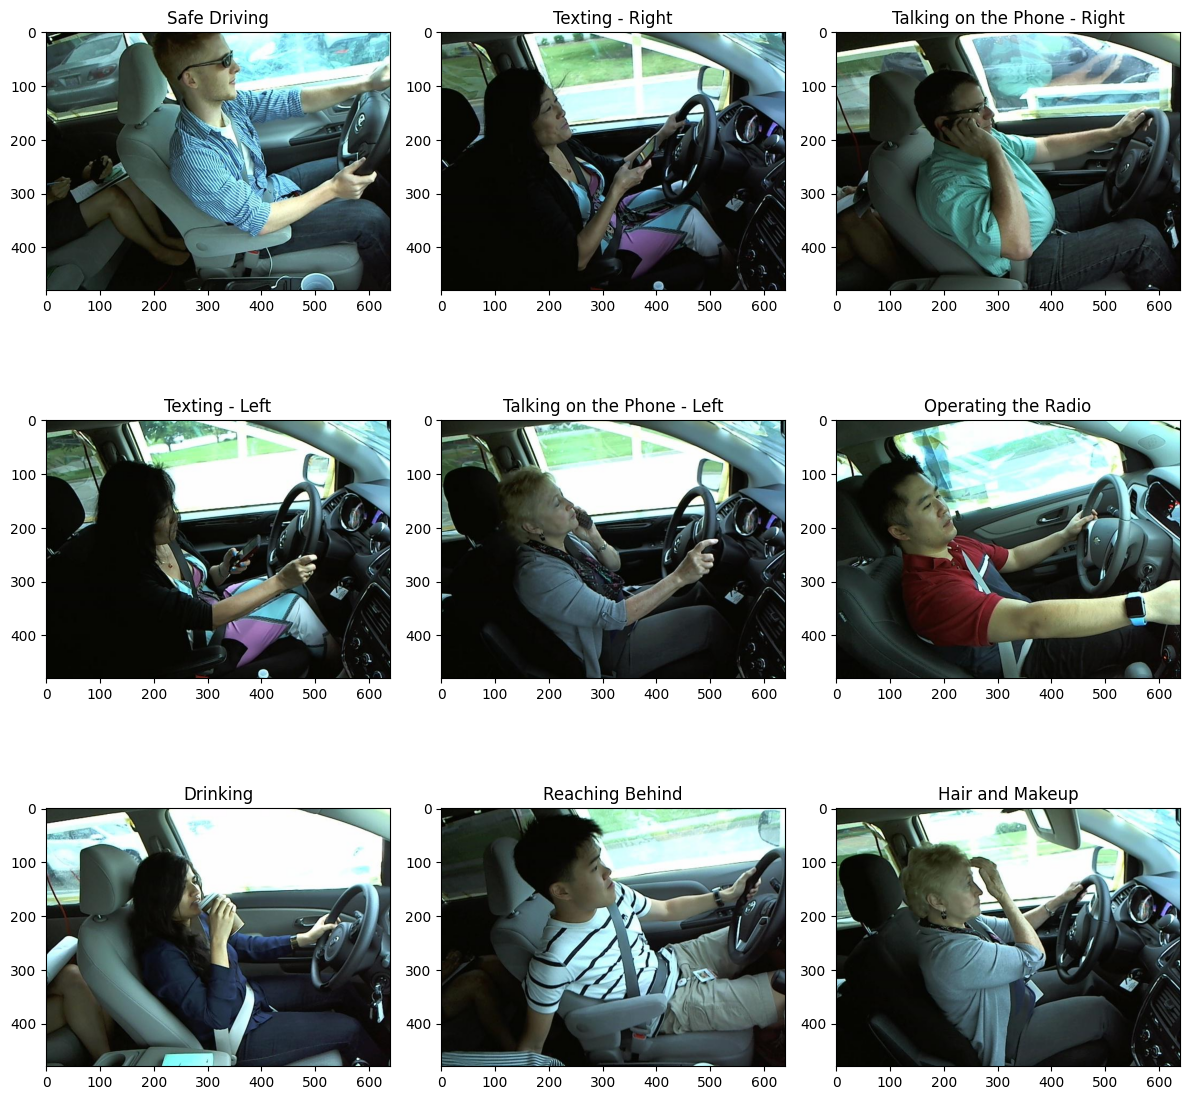

In [11]:
# Identifying the image directory where the images are stored.
image_dir = training_folder_path

# Mapping of activity titles for each type.
activity_classes = {
    "c0": "Safe Driving",
    "c1": "Texting - Right",
    "c2": "Talking on the Phone - Right",
    "c3": "Texting - Left",
    "c4": "Talking on the Phone - Left",
    "c5": "Operating the Radio",
    "c6": "Drinking",
    "c7": "Reaching Behind",
    "c8": "Hair and Makeup",
    "c9": "Talking to Passenger"
}

# Initializing a subplot to display the images.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.ravel()

# Looping through each activity type and displaying one image with the corresponding title.
for i, activity_type in enumerate(sorted(activity_classes.keys())[:9]):
    
    # Getting the path of the first image for the activity type.
    activity_dir = os.path.join(image_dir, activity_type)
    image_name = os.listdir(activity_dir)[0]
    image_path = os.path.join(activity_dir, image_name)
    
    # Loading and displaying the images.
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(activity_classes[activity_type])
    axes[i].axis('on')

# Adjusting image spacing and displaying the plots.
plt.tight_layout()
plt.show()

### **• Class and Subject Data Distribution:**

It is important to confirm that the number of images per distractor activity class and driver is balanced so that the models don't become biased towards a majority class or individual image set. This way, there will be enough generaliation and robustness and data scarcity will be avoided.

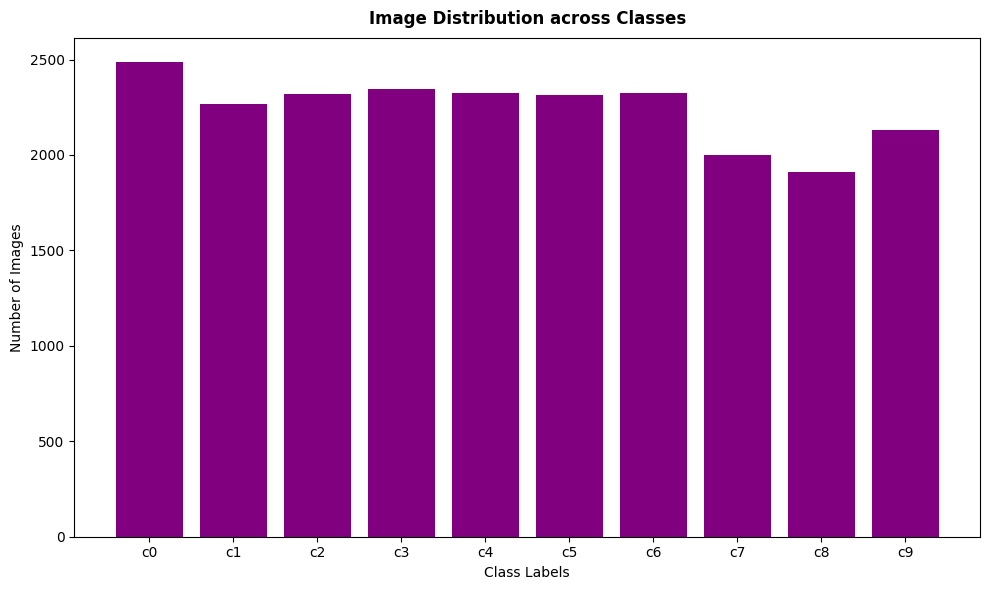

In [29]:
# Initializing empty lists to store class labels and corresponding image counts.
class_labels = []
image_counts = []

# Iterating through each subdirectory in the train directory and appending the different counts.
for subdir in os.listdir(image_dir):
    subdir_path = os.path.join(image_dir, subdir)
    if os.path.isdir(subdir_path):
        class_labels.append(subdir)
        image_counts.append(len(os.listdir(subdir_path)))

# Plotting a vertical bar chart with the class data distribution.
plt.figure(figsize=(10, 6))
plt.bar(class_labels, image_counts, color = 'purple')
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.title("Image Distribution across Classes", fontweight='bold', pad=10)
plt.tight_layout()
plt.show()

**Insight:** Since the training dataset is fairly balanced, there appears to be no need for downsampling data. 

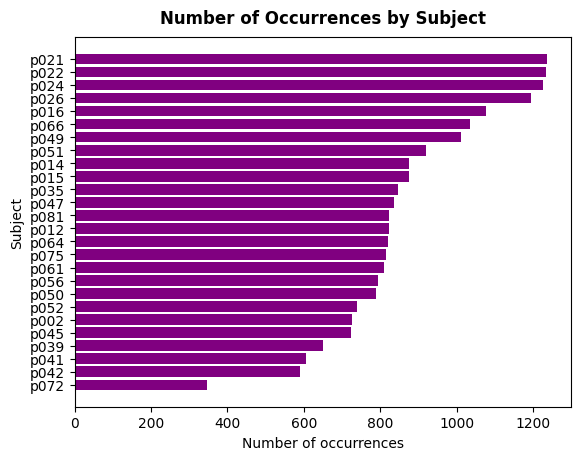

In [30]:
# Countng the number of occurrences of each subject.
subject_counts = drivers_images_list_df['subject'].value_counts()

# Sorting the subjects based on their counts in descending order.
subject_counts = subject_counts.sort_values(ascending=True)

# Creating a horizontal bar chart.
plt.barh(subject_counts.index, subject_counts.values, color = 'purple')

# Setting the chart title.
plt.title('Number of Occurrences by Subject',fontweight='bold', pad=10)

# Setting labels for the x and y axes.
plt.xlabel('Number of occurrences')
plt.ylabel('Subject')

# Displaying the chart.
plt.show()

**Insight:** As observable, some individuals have less images to be trained on. Due to this fact, it is expected that the model will learn more from the behaviour of the subjects with more available data, leading to a higher number of right predictions on their images.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## **Model 6 - MobileNetV2 (Batch 150 - SDG - α = 0.003):**

By leveraging transfer learning - a technique where an existing trained model is re-used for a given task (with some slight adaptations on the final layers) because of the performance resulting from the amount of data that was trained on, using MobileNet.

### **PART II: Data Preprocessing**

### **• Image Normalization:**

This step is commonly performed on images before feeding them into a deep learning model. By dividing each pixel value in an image by a scaling factor (in this case 255) pixel values will be brought to a standardized range between 0 and 1. In terms of the benefits of this step, 2 can be highlighted:

- **Gradient Convergence:** In order to properly update models' weights, algorithms usually work better when the input features (pixels) are within the same numerical range, hence normalization helps to increase the efficiency and stability of convergence. 

- **Model Generalization:** Normalizing pixel values usually improves models' generalization performance, as these become less sensitive to input intensity levels (i.e., dealing better with illumination, contrasts... across images).

### **• Data Augmentation:**

Data Augmentation is a crucial step in the preprocessing of image data, particularly beneficial for deep learning models. It helps to enlarge the dataset with transformed images, thus enabling the model to learn more robust features and reducing the risk of overfitting. Despite the solid number of images that were reserved for the training stage, this step will try to reduce the noise that was coming from the exterior of the car window as well as make the model more robust to different image settings.

The transformations that will be performed are the following:

- **Rotation, Width and Height Shifts:** These transformations slightly rotate the image and shift it horizontally and vertically. They allow the model to learn invariance to these perturbations.

- **Shear Transformation:** This distorts the image along an axis, which can simulate different viewing conditions.

- **Zoom:** This simulates the effect of the object being closer or further away.

- **Fill Mode:** This decides how newly created pixels will be filled after rotation or width/height shifts. The "nearest" method fills these pixels with the closest ones.

- **Brightness Range:** This randomly adjusts the brightness of the image, aiding the model in dealing with different lighting conditions.

- **Vignette Effect:** A vignette is applied to darken the periphery of the image, helping to reduce the noise from outside the car window. This encourages the model to focus on central features and reduce the impact of potentially distracting elements at the image edges.

In [16]:
# Setting the data augmentation transformations.

rotation_range = 4
width_shift_range = 0.05
height_shift_range = 0.05
shear_range = 0.04
zoom_range = 0.05
fill_mode = "nearest"
brightness_range = (0.9, 1.4)

In [17]:
# Defining the vignette preprocessing function.

def add_vignette(image):
    # Defining parameters for vignette effect.
    rows, cols = image.shape[:2]
    kernel_x = cv2.getGaussianKernel(cols,200)
    kernel_y = cv2.getGaussianKernel(rows,200)
    kernel = kernel_y * kernel_x.T
    mask = 255 * kernel / np.linalg.norm(kernel)
    output = np.copy(image)
    
    # Applying a vignette mask to each channel in the image.
    for i in range(3):
        output[:,:,i] = output[:,:,i] * mask

    return output

In [18]:
# Normalizing pixel values by dviding feature values by 255.
# Holding back 30% of the images for validation.
print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, 
                             validation_split=0.3,
                             preprocessing_function=add_vignette,
                             rotation_range=rotation_range,
                             width_shift_range=width_shift_range,
                             height_shift_range=height_shift_range,
                             shear_range=shear_range,
                             zoom_range=zoom_range,
                             fill_mode=fill_mode,
                             brightness_range=brightness_range)

Getting Data...


### **• Hyperparameter Setting 1:**

In deep learning models, instead of updating models' parameters after each individual sample training is usually performed in **batches**. This batch size should be defined in order to determine how many samples will be processed together in parallel before updating the models' weights. Larger batch sizes can lead to smoother updates to the weights since they average gradients across samples, whereas smaller batches can lead to faster convergence at the cost of some noisy updates that may add some not so good oscillations in the training process.

Additionally, it is also important to **set the right image dimensions** for the training data. Although larger sized images tend to preserve more spatial information, some of this detail may not be necessary for all types of tasks and could significantly increase the amount of computational power needed to train (leading to slower convergence).

As MobileNetV2 was already trained with different size images, in this case 224 x 224 x 3 channels (RGB), so there is a need to transform the input images' dimensions into this format.

In [19]:
# Defining a batch size.
batch_size = 150

# Defining the image dimensions.
img_size = (224,224)

### **• Set Training and Validation Data:**

The validation split is a common practice in machine learning to assess the model's performance on unseen data and prevent overfitting. By holding back a portion of the images for validation, the model can be evaluated on data it hasn't seen during training, providing a more reliable estimate of its performance on new, unseen samples. During training, the model's performance is monitored using the training set, while the validation set helps in identifying potential issues like overfitting or underfitting. It allows for adjusting model hyperparameters, such as learning rate or regularization, based on the validation performance to optimize the model's performance on unseen data.

In this case, 30% of the images will be set aside for validation, while the remaining 70% will be used for training the model.

In [20]:
# Getting the classes of the images.
classes = sorted(os.listdir(training_folder_path))
print(classes)

# Setting the Training data.
print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    training_folder_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

# Setting the Validation data.
print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    training_folder_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
Preparing training dataset...
Found 15702 images belonging to 10 classes.
Preparing validation dataset...
Found 6722 images belonging to 10 classes.


### **PART III: Model Definition**

### **• Model Elements:**

In order to define a Convolutional Neural Network (CNN) model, there are a certain elements that need to be involved:

1. **Model Type**: Sequential is a straightforward model type that allows to define a linear stack of sequential layers that build a CNN.

2. **Optimizer:** Element responsible for updating the model's parameters during training in order to minimize loss. These ones determine how models' adjust their weights based on computed gradients. Each optimizer has its own algorithm and hyperparameters.

3. **Learning Rate:** This one is the hyperparameter that controls the step size taken during each model's update of its parameters. It determines the speed at which the model learns and how quickly it converges. It is always important to define a proper learning rate value. If the learning rate is too high, the model might fail to converge into the optimal solution, if its too slow, the model might take an unecessary amount of time to find an optimal or suboptimal solution.

4. **Convolutional Layers:** These are the core blocks of CNNs. By applying kernels or filters to the input data, the network will learn spacial hierarchies of features and local patterns between pixels allowing it to be able to better classify images. These layers usually perform actions like edge, texture or shape recognition.

5. **(Optional) Padding:** This technique consists of adding extra pixels or values around the borders of an image or feature map. Padding can be useful for both maintaining the spatial information at the borders of the input and also to retain the original size of the input or feature map, allowing the subsequent layers to process information from the entire input space. There are two types of padding: "valid" and "same." In the "valid" padding scheme, no padding is added, and the output size is reduced due to the filter/kernel sliding across the input. In contrast, the "same" padding scheme adds padding equally to all sides of the input, ensuring that the output size matches the input size.

6. **(Optional) Max Pooling:** Downsampling technique that is able to reduce the spatial dimensions of the input by selecting the maximum value value within a local region of the input feature map. This step, although optional, helps reduce computational complexity by extracting only the most important features, enhancing models' translation invariance (ability of a model to recognize and understand objects or patterns regardless of their position or location within an image).

7. **(Optional) Dropout:** Regularization technique that is used to prevent overfitting and improve models' generalization performance. By randomly droping out a fraction of the input units (neurons) to zero at each update, this element forces netwroks to learn more robust and generalizable features by reducing the reliance on specific neurons and promoting distribute learning across a wider range of units.

8. **Flatten:** Since the last layers of the network expect a one-dimensional input, the flatten step is necessary in order to reshape a matrix or tensor into a vector format.

9. **Dense Layers:** Also known as fully connected layers, are layers where each neuron is connected to every other neuron in the previous and next layers. These layers can help to capture global relationships, and make the final prediction based on the learned features.

10. **Loss Function:** For multi-class classification tasks, categorical cross entropy is a popular loss function that measures the dissimilarity between the predicted class probabilities and the true class labels. The end goal of every model its to minimize this loss function during training, in order to generate more accurate class predictions.

### **• Model 6 - MobileNetV2 (Batch 150 - SGD - α = 0.003) Configuration:**

For a first attempt at building a performing model for these distracted driver actions image classification, the following custom sequence of layers and transformations will be made to the input data from scratch:

<img src="Images/mobilenetV2_architecture.png" alt="MobileNetV2" width="600"/>

1. **Initial Convolutional Layer** (Filters - 32; Kernel Size - 3x3, Stride - 2x2, Padding - Same, Activation - ReLU)

2. **Inverted Residual Block 1:**

- **Expansion Convolutional Layer** (Filters - 32; Kernel Size - 1x1, Stride - 1x1, Padding - Same, Activation - ReLU)
- **Depthwise Convolutional Layer** (Kernel Size - 3x3, Stride - 1x1, Padding - Same, Activation - ReLU)
- **Pointwise Convolutional Layer** (Filters - 16; Kernel Size - 1x1, Stride - 1x1, Padding - Same, Activation - Linear)
- **Shortcut Connection:** Skip connection from the input directly to the output
- **Element-wise Addition** of the shortcut and the main path
- **Activation** - ReLU

3. **Inverted Residual Block 2:**

- **Expansion Convolutional Layer** (Filters - 96; Kernel Size - 1x1, Stride - 1x1, Padding - Same, Activation - ReLU)
- **Depthwise Convolutional Layer** (Kernel Size - 3x3, Stride - 2x2, Padding - Same, Activation - ReLU)
- **Pointwise Convolutional Layer** (Filters - 24; Kernel Size - 1x1, Stride - 1x1, Padding - Same, Activation - Linear)
- **Shortcut Connection:** Skip connection from the input (after expansion convolution) to the output (after pointwise convolution) with a stride of 2
- **Element-wise Addition** of the shortcut and the main path
- **Activation** - ReLU

The architecture continues with a series of inverted residual blocks, gradually increasing the number of filters and adjusting the strides to downsample the spatial dimensions.

4. **Final Convolutional Layer** (Filters - 1280; Kernel Size - 1x1, Stride - 1x1, Padding - Same, Activation - ReLU)

5. **Global Average Pooling Layer** (Pool Size - Varies, depending on the input size)

6. **Fully Connected Layer** (Number of Units - # Classes, Activation - Softmax)

**(+) Advantages of this Model:**
   - **Efficiency and Speed:** MobileNetV2 is designed to be computationally efficient, making it well-suited for deployment on resource-constrained devices.
   - **Excellent Balance between Accuracy and Efficiency:** Despite its efficiency, MobileNetV2 maintains a good balance between accuracy and model size, being a lot of times used for real-time applications.
   - **Transfer Learning Capabilities:** MobileNetV2 has been pre-trained on a large-scale ImageNet dataset, enabling it to converge faster with a good accuracy due to previously learned weights.

**(-) Disadvantages of this Model:**
- **Limited Representation:** MobileNetV2's compact architecture sacrifices some representation capacity compared to deeper models. It may struggle to capture highly intricate or fine-grained features in images, which could impact performance on certain tasks that require precise detail extraction.
- **Sensitivity to Input Image Size:** MobileNetV2's performance can be sensitive to the input image size. The model is typically trained and evaluated on specific input dimensions, and deviating significantly from those dimensions may affect performance. 

In terms of the **optimizer**, the one chosen will be **SGD** - a popular and common algorithm that tries to follow the slope to the lowest point on the loss function surface.

In terms of the **loss function**, the one chosen will be **Categorical Cross Entropy**.

**- Loading MobileNetV2 model:**

In [21]:
# Loading the base model, not including its final connected layer, and set the input shape to match the one from the training images.
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

**- Freezing the already trained layers and adding add a custom output layer for the different clasess:**

In [22]:
# Freezing the already-trained layers in the base model 6.
for layer in base_model.layers:
    layer.trainable = False

In [23]:
# Creating the final layers for the classification of the input images.
x = base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classes), activation='softmax')(x) 
model_6 = Model(inputs=base_model.input, outputs=prediction_layer)

In [24]:
# Defining the optimizer.
opt_6 = optimizers.SGD(learning_rate=0.003)

In [25]:
# Compiling the model for categorical multi-class classification.
model_6.compile(loss='categorical_crossentropy',
              optimizer=opt_7,
              metrics=['accuracy'])

In [26]:
# Checking the model 6 summary.
model_6.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

### **PART IV: Training Stage**

### **• Train Model 6 - MobileNetV2 (Batch 150 - SGD - α = 0.003):**

With the layers of MobileNetV2 (Batch 150 - SGD - α = 0.003) defined, the model is ready to be trained using the training image data. In this training process, 6 iterations (epochs) will be used to train the model in 20-image batches, holding back 30% of the data for validation. After each epoch, the loss function will measure the error (loss) in the model and adjust its weights (which were randomly generated for the first iteration) to try to improve accuracy.

In [27]:
# Setting the number of epochs.
num_epochs = 6

# Training the model.
history = model_6.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/6
104/104 [==============================] - 415s 4s/step - loss: 10.0965 - accuracy: 0.6218 - val_loss: 0.4546 - val_accuracy: 0.8932
Epoch 2/6
104/104 [==============================] - 402s 4s/step - loss: 0.2089 - accuracy: 0.9415 - val_loss: 0.2399 - val_accuracy: 0.9362
Epoch 3/6
104/104 [==============================] - 405s 4s/step - loss: 0.1620 - accuracy: 0.9545 - val_loss: 0.1377 - val_accuracy: 0.9614
Epoch 4/6
104/104 [==============================] - 400s 4s/step - loss: 0.0916 - accuracy: 0.9722 - val_loss: 0.1118 - val_accuracy: 0.9677
Epoch 5/6
104/104 [==============================] - 387s 4s/step - loss: 0.0780 - accuracy: 0.9772 - val_loss: 0.1004 - val_accuracy: 0.9709
Epoch 6/6
104/104 [==============================] - 391s 4s/step - loss: 0.0595 - accuracy: 0.9820 - val_loss: 0.0741 - val_accuracy: 0.9776


### **• Visualize Loss History for Model 6 - MobileNetV2 (Batch 150 - SGD - α = 0.003) :**

Once trained, it is necessary to verify the reduction history of the loss function as well as if the model is over-fitted - learning to perform extremely well on the training data, but failing to generalize and perform well on unseen data. This overfitting can be spotted by a continuos drop in training loss after validation loss has levelled out or started to increase. 

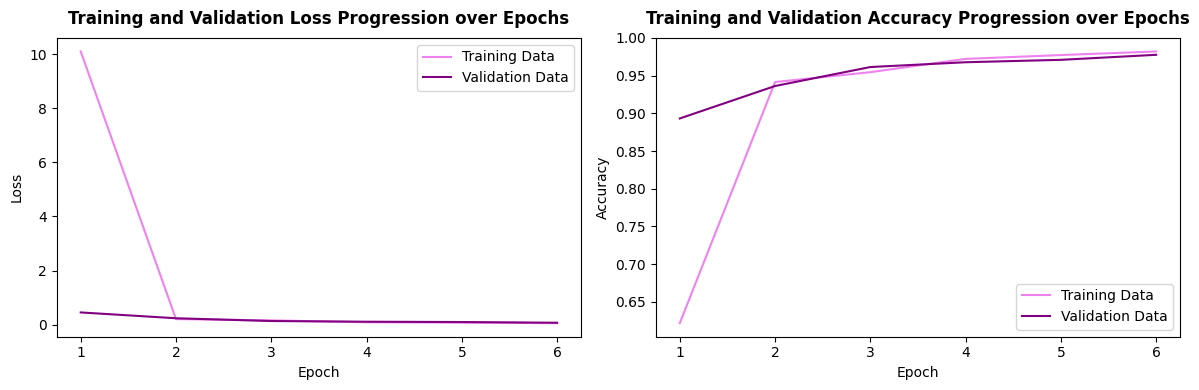

In [32]:
# Plotting the training and validation loss progression over epochs.
%matplotlib inline

# Plotting the training and validation loss progression over epochs.
plt.figure(figsize=(12, 4))

# Plotting the loss
plt.subplot(1, 2, 1)
epoch_nums = range(1, num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss, color='violet')
plt.plot(epoch_nums, validation_loss, color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training and Validation Loss Progression over Epochs", fontweight='bold', pad=10)
plt.legend(['Training Data', 'Validation Data'], loc='upper right')

# Plotting the accuracy
plt.subplot(1, 2, 2)
training_acc = history.history["accuracy"]
validation_acc = history.history["val_accuracy"]
plt.plot(epoch_nums, training_acc, color='violet')
plt.plot(epoch_nums, validation_acc, color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Validation Accuracy Progression over Epochs", fontweight='bold', pad=10)
plt.legend(['Training Data', 'Validation Data'], loc='lower right')

plt.tight_layout()
plt.show()

**Insights:** As observed, the loss on the training set decreases rapidly for the first 2 epochs (indicating that not too many epochs are needed for the network to be trained further). For the validation set, although the loss does not decrease at the exact same rate as the training set, this one remains almost flat across epochs 4-5 meaning our model is generalizing well to unseen data. In this case, it is also observable that beyond epoch 6, both the training and validation data accuracy continue to rise, hence some more epochs might have proven beneficial.

### **• Visualize Grad-CAM for Model 6 - MobileNetV2 (Batch 150 - SGD - α = 0.003) :**

In order to visualize the patterns that our model saw in the images before making a prediction, a Grad-CAM technique was applied.

1/1 [==============================] - 0s 28ms/step


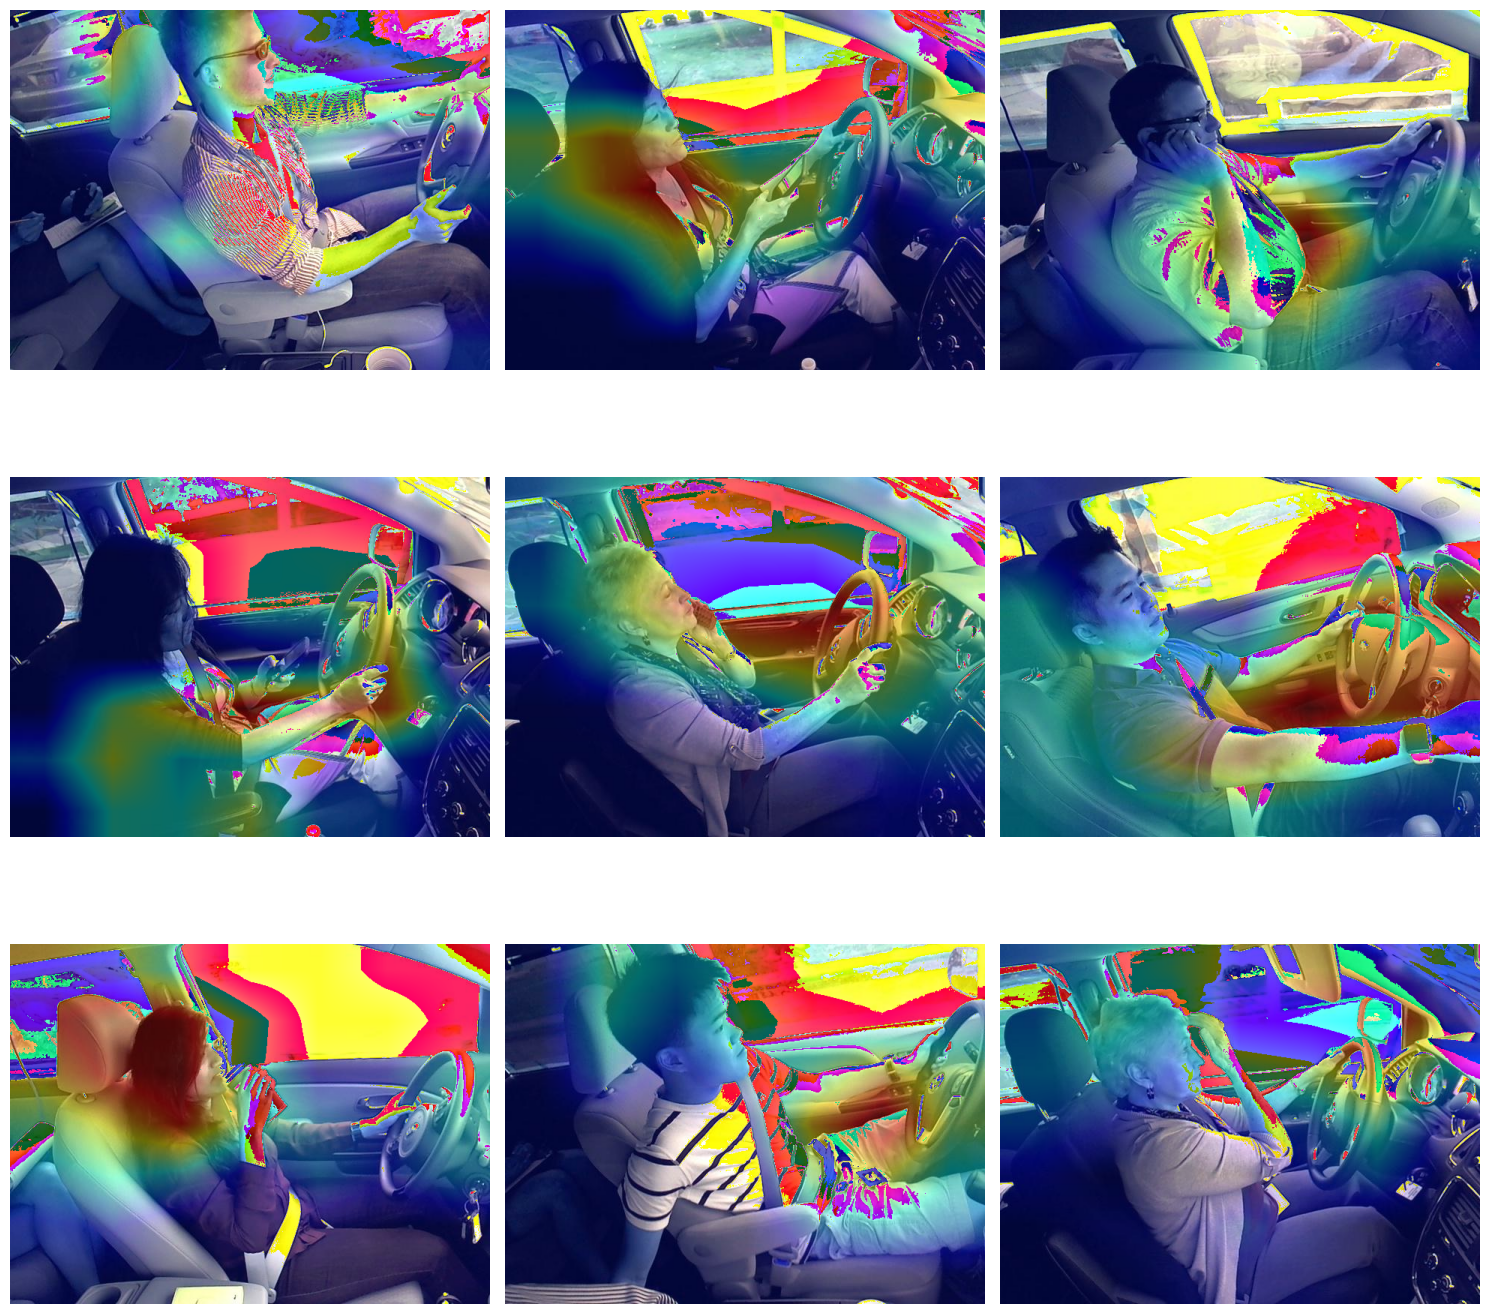

In [34]:
# Creating a list for the images.
img_paths = []

# Assigning the parent directory of the images.
parent_dir = training_folder_path

# Looping through each subdirectory in the parent directory.
for sub_dir in os.listdir(parent_dir):
    
    # Getting the path of the first image in the subdirectory.
    sub_dir_path = os.path.join(parent_dir, sub_dir)
    # Checking if it is a directory.
    if os.path.isdir(sub_dir_path):
        image_name = os.listdir(sub_dir_path)[0]
        image_path = os.path.join(sub_dir_path, image_name)

        img_paths.append(image_path)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

# Performing data transformation to match the image characteristics with which the model was trained.
for i, img_path in enumerate(img_paths[:9]):  # Limit to first 9 images
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img.astype('float32') / 255

    preds = model_6.predict(img)
    class_idx = np.argmax(preds[0])

    last_conv_layer = model_6.get_layer("Conv_1")

    grad_model = Model(
        [model_6.inputs], 
        [last_conv_layer.output, model_6.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img)
        class_channel = preds[:, class_idx]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img

    axes[i].imshow(cv2.cvtColor(np.uint8(superimposed_img), cv2.COLOR_BGR2RGB))
    axes[i].axis('off')

# Plotting the images.
plt.tight_layout()
plt.show()

**Insight:** Despite some noise that is still present from the outside environment, the model seems to have captured a good amount of detail and patterns from the subject actions.

### **PART V: Evaluation Stage**

### **• Evaluate Model 6 - MobileNetV2 (Batch 150 - SGD - α = 0.003):**

In order to evaluate how the model performs for each class, this one will be used to predict the labels for all test data and evaluate its **precision** (ratio between between the True Positives and all the Positives), **recall** (ratio between True Positives and both True Positives and False Negatives) and simple **accuracy**.

**- Confusion Matrix:**

Generating predictions from validation data...
4/4 [==============================] - 2s 429ms/step


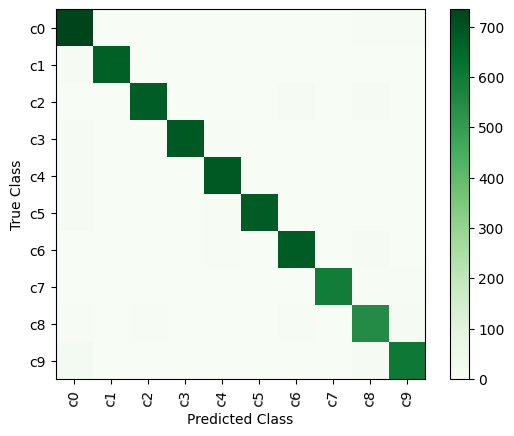

In [35]:
%matplotlib inline

# The folder contains a subfolder for each class of shape.
classes = sorted(os.listdir(training_folder_path))

print("Generating predictions from validation data...")

# Initializing lists to store predictions and true labels.
predictions = []
true_labels = []

# Iterating over each batch.
for i in range(len(validation_generator)):
    # Getting the image and label arrays for the current batch.
    x_test = validation_generator[i][0]
    y_test = validation_generator[i][1]

    # Using the model to predict the class.
    class_probabilities = model_6.predict(x_test)

    # Appending current predictions and true labels to our lists.
    predictions.extend(np.argmax(class_probabilities, axis=1))
    true_labels.extend(np.argmax(y_test, axis=1))

# Converting lists to numpy arrays.
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Plotting the confusion matrix.
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Greens)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=85)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

**- Evaluation Metrics:**

In [38]:
# Computing Precision.
precision = precision_score(true_labels, predictions, average='weighted')
print("Precision: ", precision)

# Computing Recall.
recall = recall_score(true_labels, predictions, average='weighted')
print("Recall: ", recall)

# Computing Accuracy.
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy: ", accuracy)

Precision:  0.9756734286552571
Recall:  0.9753049687592978
Accuracy:  0.9753049687592978


**Insights:**

1. **Strong Diagonal in Confusion Matrix:** The strong diagonal in the confusion matrix indicates that a majority of your predictions are accurate. The diagonal of a confusion matrix represents true positive predictions where the predicted class is equal to the actual class. A strong diagonal means your model is correctly predicting the classes for a lot of instances.

2. **High Precision:** A precision score of 0.9756 means that when your model predicts a certain class, it is correct about 97.56% of the time. In other words, the model's false positive rate is very low, indicating that the model is precise with its predictions.

3. **High Recall:** A recall score of 0.9753 means that your model identifies 97.53% of all true instances of each class. This indicates that your model has a very low false negative rate, and it's highly sensitive to detecting instances of each class.

4. **High Accuracy:** An accuracy score of 0.9753 indicates that 97.53% of all predictions made by your model are correct. This suggests that the model generalizes well to unseen data, and although this score is worst than some of the previous models, it is still a very promising one for testing.

Validating these results using a completely unseen and unlabeled test set (to ensure that the model generalizes well) will be the next step.

### **• Save Model 6 - MobileNetV2 (Batch 150 - SGD - α = 0.003) :**

Save Model 6 with the trained weights, so it can be later reloaded and used to predict classes from new images. 

In [39]:
# Naming the model.
modelFileName = 'distractions_model6_classifier.h5'

# Saving the model in keras model (.h5 file type) to use it with the test data.
model_6.save(modelFileName)
print("Model saved.")

del model_6

Model saved.


### **PART VI: Prediction Stage**

### **• Predict New Data Image Classes with Model 6 - MobileNetV2 (Batch 150 - SGD - α = 0.003):**

Use Model 6 to predict (infer) the class labels for a new set of images.

**- Create a function to resize new images to match the dimensions on which the model was trained:**

In [40]:
# Building a function to resize new images.
def resize_image(src_img, size=(224,224), bg_color="white"):
    from PIL import Image

    # Rescaling the image so the longest edge in the right size.
    src_img.thumbnail(size, Image.LANCZOS)

    # Creating a new image of the right shape.
    new_image = Image.new("RGB", size, bg_color)

    # Pasting the rescaled image onto the new background.
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))

    # Return the resized image.
    return new_image

**- Create a function to predict the class of a new image:**

In [41]:
def predict_image(classifier, image_array):
    import numpy as np

    # Reshaping the image array to include the batch size dimension.
    img_features = image_array.reshape((1, *image_array.shape))

    # Formating the input to match the training data.
    # Loading the values as floating point numbers through data generator.
    # Normalizing the pixels.
    img_features = img_features.astype('float32')
    img_features /= 255

    # Predicting the class of each input image.
    predictions = classifier.predict(img_features)

    # The prediction for each image is the class with the highest probability.
    # Getting the index of the highest probability.
    class_idx = np.argmax(predictions[0])

    # Returning the corresponding class name.
    return class_labels[int(class_idx)]

**- Predict image classes:**

In [42]:
# Loading the Model 6.
model_6 = load_model('distractions_model7_classifier.h5')

1/1 [==============================] - 0s 28ms/step


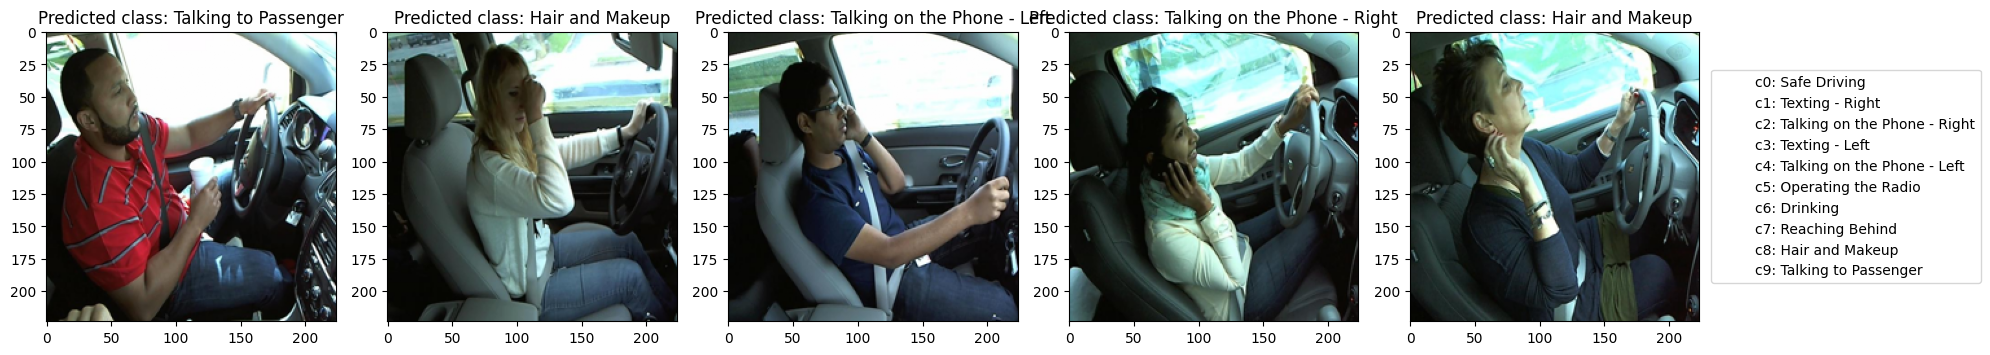

In [44]:
# Creating a function to display sample predictions.
def display_sample_predictions(model, test_folder_path, activity_classes, image_size=(224, 224)):
    import random
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image

    # Getting a list of all files in the testing folder.
    test_images = os.listdir(test_folder_path)

    # Selecting 5 random images.
    selected_images = random.sample(test_images, 5)

    plt.figure(figsize=(20,10))

    # For each selected image:
    for i, image_name in enumerate(selected_images):
        # Opening the image file.
        img_path = os.path.join(test_folder_path, image_name)
        img = Image.open(img_path)

        # Resizing the image and convert to array.
        img_resized = img.resize(image_size)
        img_array = np.array(img_resized)[np.newaxis, :]

        # Normalizing array.
        img_array = img_array.astype('float32') / 255.0

        # Predicting the image class.
        pred = model.predict(img_array)
        class_idx = np.argmax(pred)

        # Adding 'c' to the class index.
        class_name = activity_classes[f'c{class_idx}']

        # Plotting the image with its predicted class.
        plt.subplot(1, 5, i + 1)
        plt.imshow(img_array[0])
        plt.title(f'Predicted class: {class_name}')
        plt.grid(False)
    
    # Addding a legend with class labels.
    import matplotlib.patches as mpatches
    legend_patches = [mpatches.Patch(color='none', label=f'{k}: {v}') for k, v in activity_classes.items()]
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

    plt.tight_layout()
    plt.show()

# Calling the function with the model and testing folder path.
display_sample_predictions(model_6, testing_folder_path, activity_classes)

### **PART VII: Final Conclusion**

In summary, the developed model has displayed stellar performance with **high precision, recall, and accuracy metrics**. Specifically, **precision is marked at 0.9757**, **recall at 0.9753**, and **accuracy also at 0.9753**. This model is additionally **robust, boasting strong validation scores and an effective capability to accurately identify target objects within the images.**

During the **testing phase**,**the model correctly identified 4 out of the 5 images**, thus showcasing a promising potential for superior evaluation on larger datasets, surpassing the previous model. Importantly, the **SGD optimizer proved to exhibit its commendable learning capabilities.** By **defining a learning rate to 0.003**, when combined with this model's training speed, the results are still very impressive and fastly computable - positioning this model as an effective and efficient option for these sorts of problems. 

Regarding avenues for improvement, it can be hypothesized that by **changing the optimizer to some other one that converges faster**, as well as **trying a lower learning rate** might result in better and faster obtained performance metrics.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------